In [3]:
%pip install feature_engine
%pip install sktime

Note: you may need to restart the kernel to use updated packages.
  Using cached https://files.pythonhosted.org/packages/8e/a8/dbfff16296f7fe220cc2ab9bcabc525a943c2625e4d379b2ce6a42f7f434/sktime-0.14.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a9/28/2babef91a7c2f84718d8c47ecd89216913cf9e130d302208c3cfd0d17122/numba-0.56.4-cp37-cp37m-macosx_10_14_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/07/31/a5f5f578a2b19938e1bb91dcd79bd436557baf582dde23845cb0e76a2241/llvmlite-0.39.1-cp37-cp37m-macosx_10_9_x86_64.whl
  Found existing installation: llvmlite 0.29.0
ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
Note: you may need to restart the kernel to use updated packages.
  Using cached https://files.pythonhosted.org/packages/e7/ad/1df46bf1dffc5d4bba60ec98e63d4c1ad3cdd7e274c74a44dfdbdd60266b/darts-0.22.0-py3-none

  Using cached https://files.pythonhosted.org/packages/f5/9f/bf8714c28c566da38080c2ae7602a85bb3cdbd99c8974c166bfe5ce5a1bf/statsmodels-0.13.5-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/41/3d/680befd296b07e7963d637f945cfe4e7fe0d217045a2f50158cc2448a2b2/torch-1.13.0-cp37-none-macosx_10_9_x86_64.whl
  ERROR: Could not find a version that satisfies the requirement catboost>=1.0.6 (from darts) (from versions: 0.1.1, 0.1.1.2, 0.9.0a0, 0.9.0, 0.9, 0.9.1, 0.9.1.1, 0.10.0, 0.10.1, 0.10.2, 0.10.3, 0.10.4, 0.10.4.1, 0.11.0, 0.11.1, 0.11.2, 0.12.0, 0.12.1, 0.12.1.1, 0.12.2, 0.13, 0.13.1, 0.14.0, 0.14.1, 0.14.2, 0.15, 0.15.1, 0.15.2, 0.16, 0.16.1, 0.16.2, 0.16.3, 0.16.4, 0.16.5, 0.17, 0.17.1, 0.17.2, 0.17.3, 0.17.4, 0.17.5, 0.18, 0.18.1, 0.19.1, 0.20, 0.20.1, 0.20.2, 0.21, 0.22, 0.23, 0.23.1, 0.23.2, 0.24, 0.24.1, 0.24.2, 0.24.3, 0.24.4, 0.25, 0.25.1, 0.26, 0.26.1, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4)
ERROR: No matching distribution found for catboost>=1.0

In [2]:
import os
import dataframe
import pickle

# dataframe packages
import pandas as pd
import numpy as np

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

# sklearn metrics
from sklearn.metrics import (   r2_score, 
                                mean_absolute_error, 
                                mean_absolute_percentage_error, 
                                mean_squared_error)

#pipeline & Custom pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

#feature engine packages
from feature_engine.creation import CyclicalFeatures

import warnings
warnings.filterwarnings('ignore')

import datetime
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

# Calendar EDA

In [5]:
calendar = pd.read_csv('calendar.csv').pipe(reduce_mem_usage, verbose=True)
calendar['date'] = pd.to_datetime(calendar['date'])

Mem. usage decreased to  0.12 Mb (41.9% reduction)


In [13]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [14]:
calendar.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [15]:
calendar.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


In [16]:
len(calendar)

1969

In [17]:
calendar.groupby('event_type_1')['date'].count()

event_type_1
Cultural     37
National     52
Religious    55
Sporting     18
Name: date, dtype: int64

In [18]:
calendar.groupby('event_type_2')['date'].count()

event_type_2
Cultural     4
Religious    1
Name: date, dtype: int64

In [19]:
calendar.groupby('event_name_1')['date'].count()

event_name_1
Chanukah End           5
Christmas              5
Cinco De Mayo          5
ColumbusDay            5
Easter                 5
Eid al-Fitr            5
EidAlAdha              5
Father's day           4
Halloween              5
IndependenceDay        5
LaborDay               5
LentStart              6
LentWeek2              6
MartinLutherKingDay    5
MemorialDay            6
Mother's day           6
NBAFinalsEnd           6
NBAFinalsStart         6
NewYear                5
OrthodoxChristmas      5
OrthodoxEaster         5
Pesach End             6
PresidentsDay          6
Purim End              6
Ramadan starts         6
StPatricksDay          6
SuperBowl              6
Thanksgiving           5
ValentinesDay          6
VeteransDay            5
Name: date, dtype: int64

In [20]:
calendar.groupby('event_name_2')['date'].count()

event_name_2
Cinco De Mayo     1
Easter            1
Father's day      2
OrthodoxEaster    1
Name: date, dtype: int64

In [21]:
## check a few examples

calendar[calendar['event_name_1'] == 'NewYear']

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
337,2012-01-01,11149,Sunday,2,1,2012,d_338,NewYear,National,NaN,NaN,1,1,0
703,2013-01-01,11249,Tuesday,4,1,2013,d_704,NewYear,National,NaN,NaN,1,1,0
1068,2014-01-01,11349,Wednesday,5,1,2014,d_1069,NewYear,National,NaN,NaN,1,1,0
1433,2015-01-01,11448,Thursday,6,1,2015,d_1434,NewYear,National,NaN,NaN,1,1,0
1798,2016-01-01,11548,Friday,7,1,2016,d_1799,NewYear,National,NaN,NaN,1,1,0


# Sales EDA

In [22]:
%%time

sales = pd.read_csv('sales_train_evaluation.csv').pipe(reduce_mem_usage, verbose=True)

Mem. usage decreased to 95.61 Mb (78.9% reduction)
CPU times: user 3min 4s, sys: 2min 51s, total: 5min 55s
Wall time: 6min 15s


In [23]:
sales.isna().sum().sum()

0

In [24]:
sales.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30

In [25]:
sales['item_id'].nunique()

3049

In [26]:
sales['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [27]:
len(sales)

30490

# item counts in each store and category

In [12]:
item_counts = sales.groupby(['store_id', 'cat_id']).agg({'item_id':'nunique'}).reset_index()
item_counts.columns = ['store_id', 'cat_id', 'item_counts']

NameError: name 'sales' is not defined

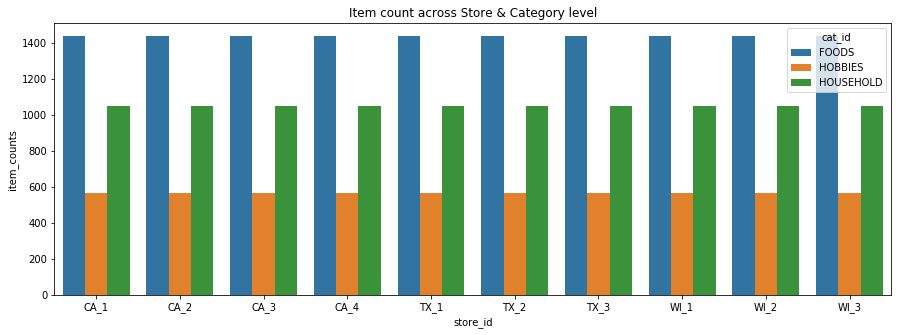

In [38]:
plt.figure(figsize = (15,5))
sns.barplot(data=item_counts, x='store_id', y='item_counts', hue='cat_id')
plt.title("Item count across each Store & Category level")
plt.show()

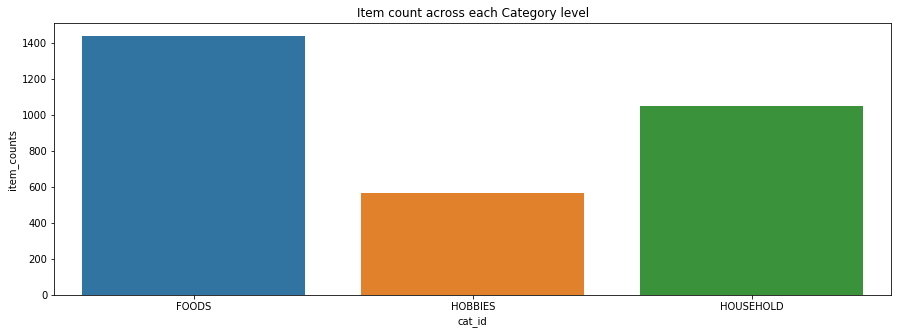

In [39]:
plt.figure(figsize = (15,5))
sns.barplot(data=item_counts, x='cat_id', y='item_counts',errwidth=0)
plt.title("Item count across each Category level")
plt.show()

In [41]:
# item counts in each store and dept

sales.pivot_table(index='store_id', columns='cat_id', values='item_id', aggfunc='count')

cat_id,FOODS,HOBBIES,HOUSEHOLD
store_id,,,
CA_1,1437,565,1047
CA_2,1437,565,1047
CA_3,1437,565,1047
CA_4,1437,565,1047
TX_1,1437,565,1047
TX_2,1437,565,1047
TX_3,1437,565,1047
WI_1,1437,565,1047
WI_2,1437,565,1047


In [42]:
np_sales = sales.loc[:, "d_1":].to_numpy().reshape(-1,)

In [43]:
np_sales

array([0, 0, 0, ..., 2, 5, 1], dtype=int16)

In [44]:
np_sales.shape

(59181090,)

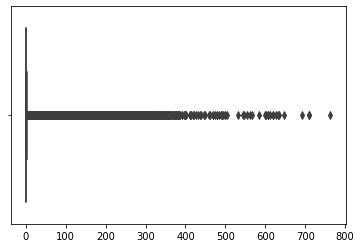

In [45]:
sns.boxplot(np_sales);

In [46]:
sales_by_date = sales.loc[:, "d_1":].T.merge(calendar, left_index=True, right_on='d', how='left').set_index('date')


In [47]:
sales_by_date.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,30253,30254,30255,30256,30257,30258,30259,30260,30261,30262,30263,30264,30265,30266,30267,30268,30269,30270,30271,30272,30273,30274,30275,30276,30277,30278,30279,30280,30281,30282,30283,30284,30285,30286,30287,30288,30289,30290,30291,30292,30293,30294,30295,30296,30297,30298,30299,30300,30301,30302,30303,30304,30305,30306,30307,30308,30309,30310,30311,30312,30313,30314,30315,30316,30317,30318,30319,30320,30321,30322,30323,30324,30325,30326,30327,30328,30329,30330,30331,30332,30333,30334,30335,30336,30337,30338,30339,30340,30341,30342,30343,30344,30345,30346,30347,30348,30349,30350,30351,30352,30353,30354,30355,30356,30357,30358,30359,30360,30361,30362,30363,30364,30365,30366,30367,30368,30369,30370,30371,30372,30373,30374,30375,30376,30377,30378,30379,30380,30381,30382,30383,30384,30385,30386,30387,30388,30389,30390,30391,30392,30393,30394,30395,30396,30397,30398,30399,30400,30401,30402,30403,30404,30405,30406,30407,30408,30409,30410,30411,30412,30413,30414,30415,30416,30417,30418,30419,30420,30421,30422,30423,30424,30425,30426,30427,30428,30429,30430,30431,30432,30433,30434,30435,30436,30437,30438,30439,30440,30441,30442,30443,30444,30445,30446,30447,30448,30449,30450,30451,30452,30453,30454,30455,30456,30457,30458,30459,30460,30461,30462,30463,30464,30465,30466,30467,30468,30469,30470,30471,30472,30473,30474,30475,30476,30477,30478,30479,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,0,0,0,2,0,0,9,0,0,0,2,0,0,0,0,0,0,0,3,0,0,1,0,0,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,2,0,0,0,0,4,0,1,0,1,5,0,0,1,0,0,0,0,2,2,1,0,25,0,0,1,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,2,0,0,3,0,0,0,0,0,3,2,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,0,45,0,0,1,0,0,0,0,0,10,0,0,0,0,0,4,0,0,0,8,0,0,0,3,5,0,0,0,0,0,3,2,0,0,0,0,0,0,4,0,0,0,3,0,0,7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,1,0,0,7,0,5,0,0,0,0,0,0,0,0,0,16,0,54,0,...,0,0,2,1,0,0,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,2,5,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,6,0,0,0,0,12,0,0,1,0,0,3,0,0,1,0,0,0,28,0,0,0,2,0,0,0,0,0,0,13,0,47,2,0,5,0,0,0,4,0,0,0,0,0,0,0,0,57,4,0,47,0,0,0,2,0,0,3,0,40,0,0,0,6,0,3,0,5,0,0,0,2,0,6,0,0,0,0,13,0,4,0,0,3,0,0,32,3,0,17,2,4,0,0,0,0,0,0,0,1,1,8,0,0,0,0,0,0,0,1,0,0,1,0,0,1,13,1,14,0,3,0,0,0,0,0,16,2,1,0,0,0,0,0,36,0,0,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
2011-

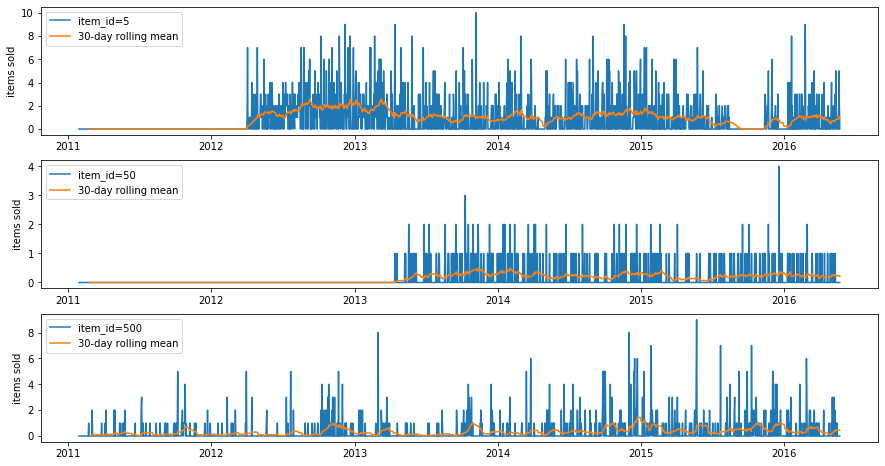

In [48]:
sample_items = [5, 50, 500]

fig, axes = plt.subplots(len(sample_items), 1, figsize=(15, 8))
for i, sample_item in enumerate(sample_items):
    axes[i].plot(sales_by_date.index, sales_by_date[sample_item], label='item_id={}'.format(sample_item))
    axes[i].plot(sales_by_date.index, sales_by_date[sample_item].rolling(30).mean(), label='30-day rolling mean')
    axes[i].set_ylabel('items sold')
    axes[i].legend()

In [49]:
sales_by_date = sales_by_date.pipe(reduce_mem_usage, verbose=True)

Mem. usage decreased to 113.00 Mb (0.0% reduction)


In [42]:
sales_by_date

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,30253,30254,30255,30256,30257,30258,30259,30260,30261,30262,30263,30264,30265,30266,30267,30268,30269,30270,30271,30272,30273,30274,30275,30276,30277,30278,30279,30280,30281,30282,30283,30284,30285,30286,30287,30288,30289,30290,30291,30292,30293,30294,30295,30296,30297,30298,30299,30300,30301,30302,30303,30304,30305,30306,30307,30308,30309,30310,30311,30312,30313,30314,30315,30316,30317,30318,30319,30320,30321,30322,30323,30324,30325,30326,30327,30328,30329,30330,30331,30332,30333,30334,30335,30336,30337,30338,30339,30340,30341,30342,30343,30344,30345,30346,30347,30348,30349,30350,30351,30352,30353,30354,30355,30356,30357,30358,30359,30360,30361,30362,30363,30364,30365,30366,30367,30368,30369,30370,30371,30372,30373,30374,30375,30376,30377,30378,30379,30380,30381,30382,30383,30384,30385,30386,30387,30388,30389,30390,30391,30392,30393,30394,30395,30396,30397,30398,30399,30400,30401,30402,30403,30404,30405,30406,30407,30408,30409,30410,30411,30412,30413,30414,30415,30416,30417,30418,30419,30420,30421,30422,30423,30424,30425,30426,30427,30428,30429,30430,30431,30432,30433,30434,30435,30436,30437,30438,30439,30440,30441,30442,30443,30444,30445,30446,30447,30448,30449,30450,30451,30452,30453,30454,30455,30456,30457,30458,30459,30460,30461,30462,30463,30464,30465,30466,30467,30468,30469,30470,30471,30472,30473,30474,30475,30476,30477,30478,30479,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,0,0,0,2,0,0,9,0,0,0,2,0,0,0,0,0,0,0,3,0,0,1,0,0,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,2,0,0,0,0,4,0,1,0,1,5,0,0,1,0,0,0,0,2,2,1,0,25,0,0,1,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,2,0,0,3,0,0,0,0,0,3,2,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,0,45,0,0,1,0,0,0,0,0,10,0,0,0,0,0,4,0,0,0,8,0,0,0,3,5,0,0,0,0,0,3,2,0,0,0,0,0,0,4,0,0,0,3,0,0,7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,1,0,0,7,0,5,0,0,0,0,0,0,0,0,0,16,0,54,0,...,0,0,2,1,0,0,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,2,5,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,6,0,0,0,0,12,0,0,1,0,0,3,0,0,1,0,0,0,28,0,0,0,2,0,0,0,0,0,0,13,0,47,2,0,5,0,0,0,4,0,0,0,0,0,0,0,0,57,4,0,47,0,0,0,2,0,0,3,0,40,0,0,0,6,0,3,0,5,0,0,0,2,0,6,0,0,0,0,13,0,4,0,0,3,0,0,32,3,0,17,2,4,0,0,0,0,0,0,0,1,1,8,0,0,0,0,0,0,0,1,0,0,1,0,0,1,13,1,14,0,3,0,0,0,0,0,16,2,1,0,0,0,0,0,36,0,0,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
2011-

In [11]:
df_sales_data = pd.read_pickle("df_consolidated.pkl")

In [ ]:
df_sales_data["month"] = df_sales_data["date"].astype("datetime64[ns]").dt.month
df_sales_data["month"] = np.where(len(df_sales_data["month"]) <= 1,
                                          "0"+str(df_sales_data["month"]), df_sales_data["month"])
df_sales_data["month"].unique()

# Sales by store

In [ ]:
pd.pivot_table(df_sales_data, values = "sold", 
               index = ["year"], columns = ["store_id"], aggfunc = sum).\
                plot(figsize = (15,7))
plt.ylabel("Sales")
plt.title("Sales across different stores in USA")
plt.show()

In [61]:
pd.pivot_table(df_sales_data, values = "sold", 
               index = ["year"], columns = ["store_id"], aggfunc = sum)

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
year,,,,,,,,,,
2011,1060793.0,826083.0,1520827.0,536099.0,799556.0,1060623.0,850980.0,540021.0,566254.0,1095349.0
2012,1406432.0,1032484.0,2099706.0,729865.0,1064111.0,1460222.0,1087198.0,725388.0,1018731.0,1437700.0
2013,1538540.0,1121532.0,2249633.0,824096.0,1105570.0,1536308.0,1136181.0,1021094.0,1401490.0,1201309.0
2014,1577931.0,1010213.0,2314556.0,846176.0,1105564.0,1331780.0,1235871.0,1153819.0,1460410.0,1053456.0
2015,1606863.0,1208421.0,2276753.0,875101.0,1151251.0,1364799.0,1342873.0,1274924.0,1507628.0,1192198.0
2016,641689.0,619662.0,902065.0,371197.0,466771.0,575910.0,552837.0,546260.0,743475.0,562545.0


# Sales by department id

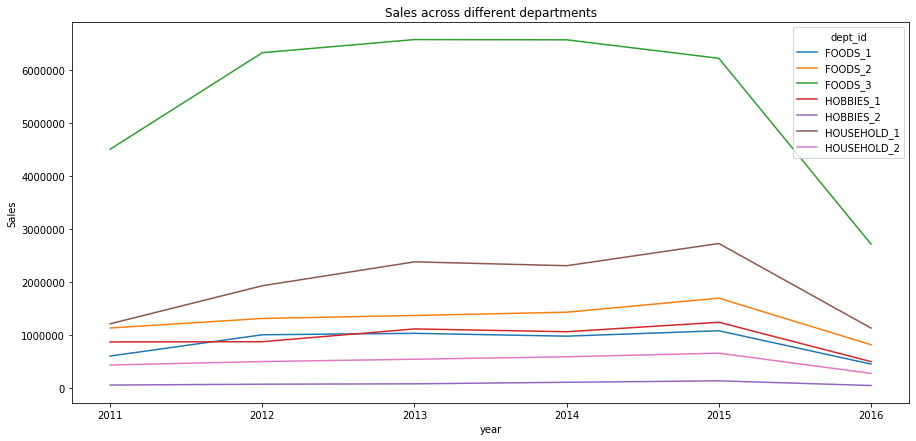

In [66]:
pd.pivot_table(df_sales_data, values = "sold", 
               index = ["year"], columns = ["dept_id"], aggfunc = sum).\
                plot(figsize = (15,7))
plt.ylabel("Sales")
plt.title("Sales across different departments")
plt.show()

In [65]:
pd.pivot_table(df_sales_data, values = "sold", 
               index = ["year"], columns = ["dept_id"], aggfunc = sum)

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
year,,,,,,,
2011,610070.0,1139010.0,4509784.0,875816.0,63335.0,1217866.0,440704.0
2012,1011192.0,1318851.0,6330225.0,880654.0,79183.0,1935393.0,506339.0
2013,1038468.0,1375190.0,6577824.0,1121641.0,86418.0,2386323.0,549889.0
2014,984877.0,1437226.0,6573422.0,1068373.0,115473.0,2313698.0,596707.0
2015,1087217.0,1701887.0,6224751.0,1247530.0,142625.0,2732398.0,664403.0
2016,458576.0,822861.0,2720996.0,505000.0,54608.0,1137175.0,283195.0


# Sales by category id

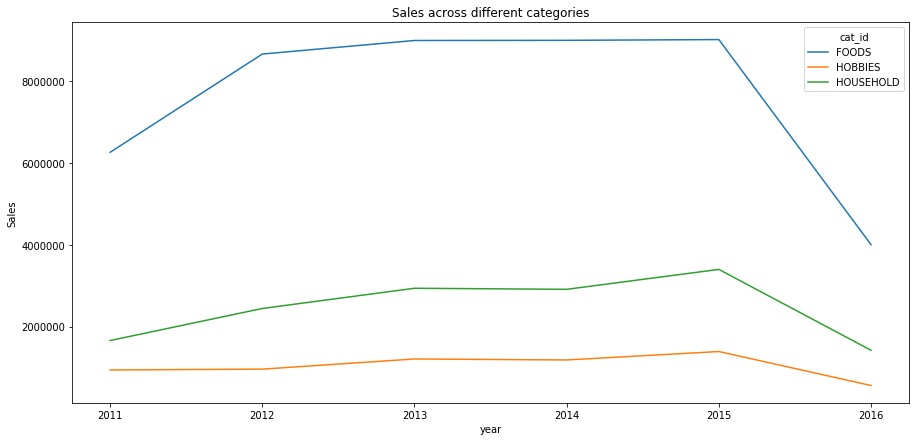

In [68]:
pd.pivot_table(df_sales_data, values = "sold", 
               index = ["year"], columns = ["cat_id"], aggfunc = sum).\
                plot(figsize = (15,7))
plt.ylabel("Sales")
plt.title("Sales across different categories")
plt.show()

In [69]:
pd.pivot_table(df_sales_data, values = "sold", 
               index = ["year"], columns = ["cat_id"], aggfunc = sum)

cat_id,FOODS,HOBBIES,HOUSEHOLD
year,,,
2011,6258864.0,939151.0,1658570.0
2012,8660268.0,959837.0,2441732.0
2013,8991482.0,1208059.0,2936212.0
2014,8995525.0,1183846.0,2910405.0
2015,9013855.0,1390155.0,3396801.0
2016,4002433.0,559608.0,1420370.0
